In [1]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00


In [2]:
pip install pyngrok

In [3]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

In [4]:
# Chargement des données
df = pd.read_csv("/content/train_tracking.csv")
X = df.drop(columns=["TARGET"])
y = df["TARGET"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:

# Fonction de calcul des métriques
def eval_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


### **Experience 1: Parametre 1**

In [6]:

# Entraînement avec variation d'hyperparamètres
mlflow.set_experiment("Credit Scoring Models 1")

model_grid = {
    "RandomForest": {
        "class": RandomForestClassifier,
        "params_grid": {
            "n_estimators": [100],
            "max_depth": [5],
            "random_state": [42]
        }
    },
    "LogisticRegression": {
        "class": LogisticRegression,
        "params_grid": {
            "C": [0.5],
            "solver": ["liblinear"],
            "max_iter": [1000]
        }
    },
    "XGBoost": {
        "class": xgb.XGBClassifier,
        "params_grid": {
            "n_estimators": [100],
            "max_depth": [3],
            "learning_rate": [0.1],
            "use_label_encoder": [False],
            "eval_metric": ["logloss"]
        }
    },
    # "LightGBM": {
    #     "class": lgb.LGBMClassifier,
    #     "params_grid": {
    #         "n_estimators": [100, 200],
    #         "max_depth": [3, 4],
    #         "learning_rate": [0.1]
    #     }
    # }
}

from itertools import product

for name, cfg in model_grid.items():
    keys, values = zip(*cfg["params_grid"].items())
    for v in product(*values):
        params = dict(zip(keys, v))
        with mlflow.start_run(run_name=f"{name}"):
            model = cfg["class"](**params)
            model.fit(X_train, y_train)

            preds = model.predict(X_val)
            probas = model.predict_proba(X_val)[:, 1]

            metrics = eval_metrics(y_val, preds, probas)

            mlflow.log_params(params)
            mlflow.log_metrics(metrics)

            mlflow.sklearn.log_model(model, name)


2025/04/01 23:53:32 INFO mlflow.tracking.fluent: Experiment with name 'Credit Scoring Models 1' does not exist. Creating a new experiment.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/04/01 23:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/04/01 23:54:24 WARNING mlflow.models.model

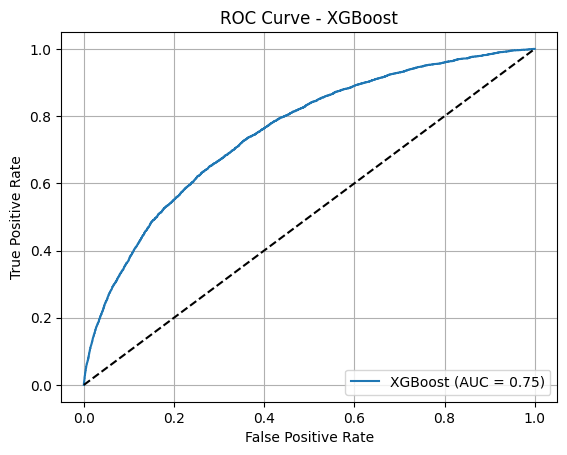

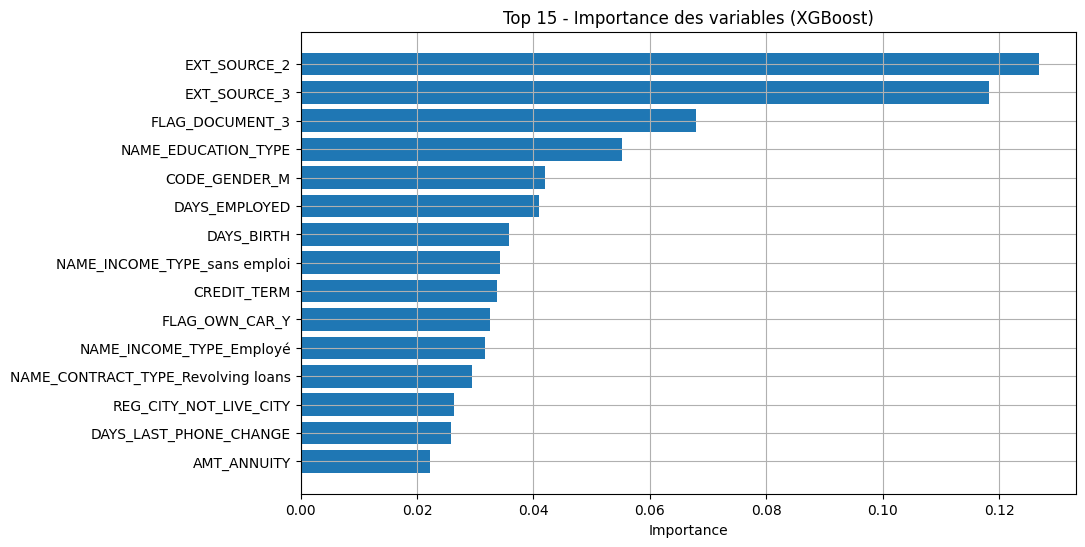

In [7]:

# Visualisation : courbe ROC et importance des variables
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, model_name, top_n=15):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = model.coef_[0]
    else:
        print(f"Aucune importance des variables disponible pour {model_name}")
        return
    features = X.columns
    sorted_idx = importances.argsort()[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[sorted_idx], align="center")
    plt.yticks(range(top_n), [features[i] for i in sorted_idx])
    plt.title(f"Top {top_n} - Importance des variables ({model_name})")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.show()

# Exemple d'affichage pour le dernier modèle entraîné
plot_roc(y_val, probas, name)
plot_feature_importance(model, name)


### **Experience 2: Parametre 2**

In [8]:

# Entraînement avec variation d'hyperparamètres
mlflow.set_experiment("Credit Scoring Models 2")

model_grid = {
    "RandomForest": {
        "class": RandomForestClassifier,
        "params_grid": {
            "n_estimators": [200],
            "max_depth": [10],
            "random_state": [42]
        }
    },
    "LogisticRegression": {
        "class": LogisticRegression,
        "params_grid": {
            "C": [1.0],
            "solver": ["liblinear"],
            "max_iter": [1000]
        }
    },
    "XGBoost": {
        "class": xgb.XGBClassifier,
        "params_grid": {
            "n_estimators": [200],
            "max_depth": [4],
            "learning_rate": [0.1],
            "use_label_encoder": [False],
            "eval_metric": ["logloss"]
        }
    },
    # "LightGBM": {
    #     "class": lgb.LGBMClassifier,
    #     "params_grid": {
    #         "n_estimators": [100, 200],
    #         "max_depth": [3, 4],
    #         "learning_rate": [0.1]
    #     }
    # }
}

from itertools import product

for name, cfg in model_grid.items():
    keys, values = zip(*cfg["params_grid"].items())
    for v in product(*values):
        params = dict(zip(keys, v))
        with mlflow.start_run(run_name=f"{name}"):
            model = cfg["class"](**params)
            model.fit(X_train, y_train)

            preds = model.predict(X_val)
            probas = model.predict_proba(X_val)[:, 1]

            metrics = eval_metrics(y_val, preds, probas)

            mlflow.log_params(params)
            mlflow.log_metrics(metrics)

            mlflow.sklearn.log_model(model, name)


2025/04/01 23:54:35 INFO mlflow.tracking.fluent: Experiment with name 'Credit Scoring Models 2' does not exist. Creating a new experiment.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/04/01 23:56:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/04/01 23:56:26 WARNING mlflow.models.model

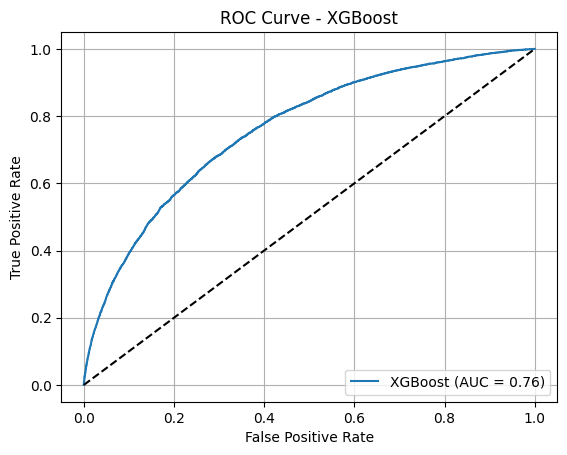

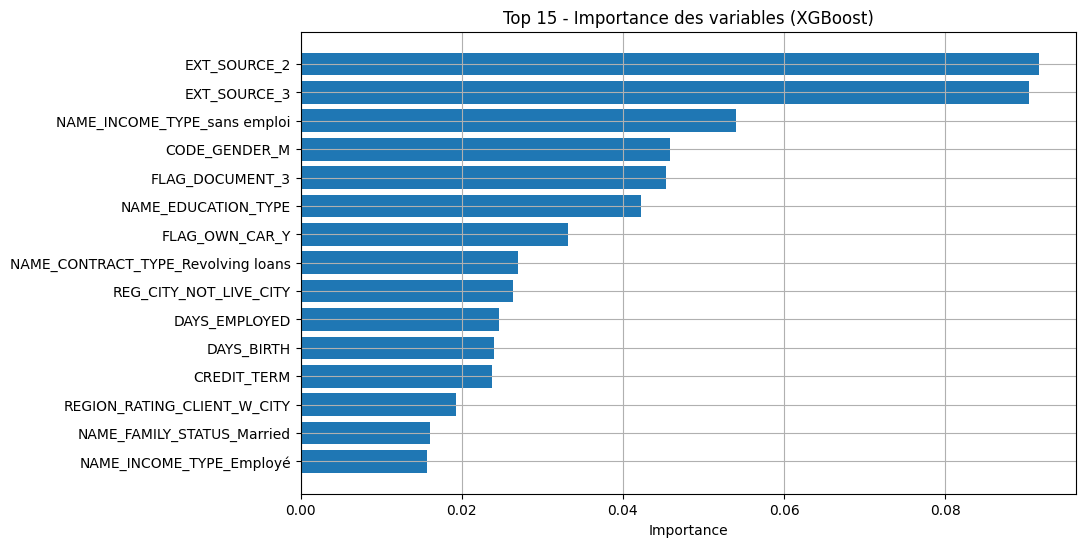

In [9]:

# Visualisation : courbe ROC et importance des variables
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, model_name, top_n=15):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = model.coef_[0]
    else:
        print(f"Aucune importance des variables disponible pour {model_name}")
        return
    features = X.columns
    sorted_idx = importances.argsort()[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[sorted_idx], align="center")
    plt.yticks(range(top_n), [features[i] for i in sorted_idx])
    plt.title(f"Top {top_n} - Importance des variables ({model_name})")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.show()

# Exemple d'affichage pour le dernier modèle entraîné
plot_roc(y_val, probas, name)
plot_feature_importance(model, name)


In [10]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2uutQpO1dffpr4H6XQURtpHXUCv_6y5AVmgNaLFCieBXoSw9r"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPS tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9aad-34-74-131-43.ngrok-free.app


In [ ]:
!mlflow ui

[2025-04-01 23:56:48 +0000] [2473] [INFO] Starting gunicorn 23.0.0
[2025-04-01 23:56:48 +0000] [2473] [INFO] Listening at: http://127.0.0.1:5000 (2473)
[2025-04-01 23:56:48 +0000] [2473] [INFO] Using worker: sync
[2025-04-01 23:56:48 +0000] [2474] [INFO] Booting worker with pid: 2474
[2025-04-01 23:56:48 +0000] [2475] [INFO] Booting worker with pid: 2475
[2025-04-01 23:56:48 +0000] [2476] [INFO] Booting worker with pid: 2476
[2025-04-01 23:56:48 +0000] [2477] [INFO] Booting worker with pid: 2477
